In [1]:
import json
import pandas as pd
import MeCab
import matplotlib.pyplot as plt
import csv
import numpy as np
from wordcloud import WordCloud
from janome.analyzer import Analyzer
from janome.charfilter import UnicodeNormalizeCharFilter, RegexReplaceCharFilter
from janome.tokenizer import Tokenizer as JanomeTokenizer  # sumyのTokenizerと名前が被るため
from janome.tokenfilter import POSKeepFilter, ExtractAttributeFilter
import re
import ipadic

import unicodedata
#Algos
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.reduction import ReductionSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.summarizers.kl import KLSummarizer
from janome.tokenizer import Tokenizer as JanomeTokenizer
from janome.analyzer import Analyzer
from janome.charfilter import *
from janome.tokenfilter import *
from sumy.utils import get_stop_words

import pkg_resources, imp
imp.reload(pkg_resources)
import unicodedata
import spacy
nlp = spacy.load('ja_ginza')#spacyの日本語モデル(Ginza)をロード

from ginza import *
import neologdn
import re
import emoji
import mojimoji
from collections import Counter





C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
import sys
import pandas as pd
#
import sqlite3
# ------------------------------------------------------------------
sys.stderr.write("*** 開始 ***\n")
#読み込み先
file_company = "./datas/OpenWork_company.db"
file_company_info = './datas/OpenWork_company_info.db'

conn = sqlite3.connect(file_company)
conn2 = sqlite3.connect(file_company_info)
#
company_df=pd.read_sql_query('SELECT * FROM df_company', conn)
company_info_df=pd.read_sql_query('SELECT * FROM df_company_info', conn2)
display(company_df.head(15))
display(company_info_df.head(15))
#
conn.close()
conn2.close()
sys.stderr.write("*** 終了 ***\n")

#複数行に値が重複している可能性があるためdrop_duplicatesで、1行1ユニーク値にする
company_df = company_df.drop_duplicates()
company_info_df = company_info_df.drop_duplicates()

company_info_df.tail()

*** 開始 ***


,企業名,企業ID,口コミ種別ID,回答日時,評価,本文,業種,口コミ種別,職種,経験年数,現職/退職,新卒/中途,性別
0,株式会社極洋,a0910000000Fqdi,1,2021年09月16日,2.9,典型的な昔の会社。上の人間になればなるほど安定を好み、チャレンジ精神や新しい文化を取り入れる...,食品、飲料,組織体制・企業文化,水産,営業,在籍3年未満,現職（回答時）,新卒入社
1,株式会社極洋,a0910000000Fqdi,1,2018年04月12日,3.8,一部上場企業なので土台はしっかりしている。歴史も80年以上あるので、それだけ続いてきた会社な...,食品、飲料,組織体制・企業文化,管理部門,在籍3～5年,退社済み(2015年より前),新卒入社,女性
2,株式会社極洋,a0910000000Fqdi,1,2017年05月17日,2.8,水産、加工食品、常温、鰹鮪の４事業が主力。本社、支社に分けられる。支社が販社、独立採算制。人...,食品、飲料,組織体制・企業文化,営業,在籍10～15年,退社済み(2020年より前),新卒入社,男性
3,株式会社極洋,a0910000000Fqdi,1,2018年03月05日,3.3,良い意味では会社が古く、福利厚生・給与等安定している。また、基本的にクビにもならない。悪い意...,食品、飲料,組織体制・企業文化,社員,在籍3～5年,現職（回答時）,新卒入社,男性
4,株式会社極洋,a0910000000Fqdi,1,2018年01月04日,2.6,古い会社なので年功序列、上の言うことは絶対の風潮があり、風通しは悪い。また年齢構成がいびつに...,食品、飲料,組織体制・企業文化,営業,在籍5～10年,現職（回答時）,新卒入社,男性
5,株式会社極洋,a0910000000Fqdi,1,2015年07月17日,3.3,水産気質というか、たくましい人が多い。上下関係は厳しかったが、根が優しい人が多かった印象。実...,食品、飲料,組織体制・企業文化,営業,在籍3～5年,退社済み(2015年より前),新卒入社,男性
6,日本水産株式会社,a0910000000Fqdk,1,2016年03月25日,2.0,終身雇用・年功序列・新卒偏重・男性社会などの昭和の遺産から脱却できていない。それらに当てはま...,食品、飲料,組織体制・企業文化,事務,在籍5～10年,現職（回答時）,中途入社,女性
7,日本水産株式会社,a0910000000Fqdk,1,2017年04月12日,2.9,体育会系かと思います。お客様が第一、上司が第一。食品と水産とファイン事業があるので部署により...,食品、飲料,組織体制・企業文化,マーケティング,在籍5～10年,現職（回答時）,新卒入社,女性
8,日本水産株式会社,a0910000000Fqdk,1,2016年09月19日,2.4,社長が交代して変わった可能性があるが、「臭いものには蓋をする」という風土があったと思う。何か...,食品、飲料,組織体制・企業文化,管理部門,在籍3～5年,退社済み(2015年より前),中途入社,女性
9,日本水産株式会社,a0910000000Fqdk,1,2016年03月03日,2.8,創業100年を超えている老舗企業であるので、組織体制及び企業文化については良くも悪くも老舗の...,食品、飲料,組織体制・企業文化,営業,在籍10～15年,退社済み(2015年より前),新卒入社,男性


,企業名,月残業時間,有給消化率,平均年収,設立年,総合スコア,社員の士気,風通し,社員相互尊重,20代成長性,長期育成,コンプラ,評価納得感,待遇満足度,業種
0,シークス,16.9,36.9,None,1937.0,3.00,3.3,2.9,2.4,3.1,2.5,3.2,3.2,3.5,食品、飲料
1,日本水産株式会社,31.1,59.0,None,1943.0,2.98,2.9,2.9,2.5,2.6,2.3,4.1,4.1,3.5,食品、飲料
2,マルハニチロ株式会社,16.2,49.3,530,1943.0,3.15,2.9,3.1,2.9,3.2,2.9,4.4,4.4,2.9,食品、飲料
3,株式会社ホウスイ,None,None,None,1945.0,2.93,2.9,2.9,2.9,3.0,2.8,2.9,2.9,3.2,食品、飲料
4,株式会社雪国まいたけ,14.3,46.6,None,2015.0,2.48,2.4,2.4,2.5,2.2,2.3,2.7,2.7,2.7,食品、飲料
5,カネコ種苗株式会社,20.2,20.0,None,1947.0,2.76,2.8,2.4,2.8,2.5,2.2,3.6,3.6,2.8,農業、林業、水産、畜産
6,株式会社サカタのタネ,10.7,54.8,None,1942.0,3.20,2.8,3.6,3.1,2.6,2.9,4.0,4.0,3.6,農業、林業、水産、畜産
7,ホクト株式会社（食品）,21.4,58.2,423,1964.0,2.85,3.0,2.7,3.4,2.6,2.6,3.2,3.2,2.7,食品、飲料
8,株式会社ホクリヨウ,29.0,37.0,None,1949.0,2.89,2.9,2.9,2.8,2.7,2.9,3.0,3.0,3.0,食品、飲料
9,株式会社ヒノキヤグループ,32.2,39.6,None,1988.0,2.89,2.9,3.0,2.9,2.9,2.9,3.0,3.0,2.7,不動産関連、住宅


*** 終了 ***


,企業名,月残業時間,有給消化率,平均年収,設立年,総合スコア,社員の士気,風通し,社員相互尊重,20代成長性,長期育成,コンプラ,評価納得感,待遇満足度,業種
2210,アマゾンジャパン合同会社,28.8,69.8,1004,2000.0,3.88,3.8,4.0,3.1,3.6,2.4,4.4,4.4,4.2,インターネット
2211,日本マイクロソフト株式会社,36.8,60.6,1290,1986.0,4.22,4.1,4.2,3.8,3.7,2.7,4.8,4.8,4.6,SIer、ソフト開発、システム運用
2212,アクセンチュア株式会社,39.0,66.2,854,1995.0,4.24,4.2,4.3,3.9,4.6,3.0,3.8,3.8,4.1,コンサルティング、シンクタンク
2213,日本アイ・ビー・エム株式会社（IBM）,38.9,49.8,915,1937.0,4.02,3.5,4.2,3.7,4.0,3.2,4.6,4.6,3.4,SIer、ソフト開発、システム運用
2214,株式会社セールスフォース・ジャパン（旧：株式会社セールスフォース・ドットコム）,39.3,58.9,1223,2000.0,4.65,4.6,4.5,4.1,4.6,3.8,4.6,4.6,4.6,SIer、ソフト開発、システム運用


In [3]:
import numpy as np
import pandas as pd

#company_dfの前処理
company_df.本文 = company_df.本文.str.replace('\u3000', ' ')
company_df.本文 = company_df.本文.str.replace('■', ' ')
company_df.本文 = company_df.本文.str.replace('⇒', ' ')
company_df.本文 = company_df.本文.str.replace('→', ' ')
company_df.本文 = company_df.本文.str.replace('□', ' ')
company_df.本文 = company_df.本文.str.replace('：', ' ')

#company_info_dfの前処理
def preprocessing(company_info_df):
        
    #まず、'--'が含まれている場合はNaNに置き換える
    replace_line = company_info_df.replace('--',None)

    #欠損していない値が3未満の企業はdrop
    processed_company_info_df = replace_line.dropna(axis=1, thresh=3,  inplace=False)

    #obj→floatに変換
    processed_company_info_df.月残業時間 = processed_company_info_df.月残業時間.astype('float')
    processed_company_info_df.有給消化率 = processed_company_info_df.有給消化率.astype('float')
    processed_company_info_df.平均年収  = processed_company_info_df.平均年収.astype('float')
    processed_company_info_df.総合スコア = processed_company_info_df.総合スコア.astype('float')
    processed_company_info_df.社員の士気 = processed_company_info_df.社員の士気.astype('float')
    processed_company_info_df.風通し = processed_company_info_df.風通し.astype('float')
    processed_company_info_df.社員相互尊重 = processed_company_info_df.社員相互尊重.astype('float')
    processed_company_info_df['20代成長性'] = processed_company_info_df['20代成長性'].astype('float')
    processed_company_info_df.長期育成 = processed_company_info_df.長期育成.astype('float')
    processed_company_info_df.コンプラ = processed_company_info_df.コンプラ.astype('float')
    processed_company_info_df.評価納得感 = processed_company_info_df.評価納得感.astype('float')
    processed_company_info_df.待遇満足度 = processed_company_info_df.待遇満足度.astype('float')
    
    #Nullは中央値で埋める
    processed_company_info_df = processed_company_info_df.fillna(value=processed_company_info_df.median())
    
    #その他、分析に必要なdfの必要な前処理
    processed_company_info_df['会社年齢'] = 2022 - processed_company_info_df['設立年']
    processed_company_info_df.drop('設立年',axis=1,inplace=True)
    
    return processed_company_info_df

company_info_df_processed = preprocessing(company_info_df)

In [23]:
word_list=[]        
while node:
    word_type = node.feature.split(',')[0]
    if word_type in ["名詞", "動詞", "形容詞",'副詞']:
        word_list.append(node.surface)
    
    #ここのインデントミスると無限ループ
    node = node.next

# リストを文字列に変換
word_chain = ' '.join(word_list)

In [65]:
company_info_mean = company_info_df_processed.groupby('業種').agg(np.mean).round(2).reset_index()
company_industry_avg = company_info_mean[company_info_mean.業種 == company_info_df[company_info_df.企業名 == C.company_name].業種.str.cat()]

company_industry_avg

,業種,月残業時間,有給消化率,平均年収,総合スコア,社員の士気,風通し,社員相互尊重,20代成長性,長期育成,コンプラ,評価納得感,待遇満足度,会社年齢
7,ゲーム関連、玩具,27.36,61.68,551.24,3.04,2.88,3.08,3.12,2.82,2.32,4.02,4.02,2.93,41.47


In [38]:
#stopword list 
stopword_list = []
with open('./stopwords/stopwords.csv','r',encoding='utf-8') as f:
    text = f.readlines()
    for tk in text:
        tk = tk.strip('\n')
        tk = tk.replace('\ufeff','')
        stopword_list.append(tk)


株式会社バンダイナムコエンターテインメント

該当企業の分野別評価



,企業名,月残業時間,有給消化率,平均年収,総合スコア,社員の士気,風通し,社員相互尊重,20代成長性,長期育成,コンプラ,評価納得感,待遇満足度,会社年齢
1596,株式会社バンダイナムコエンターテインメント,27.0,63.2,725.0,3.65,3.4,3.7,3.3,3.8,2.7,4.4,4.4,3.6,67.0


該当企業の業種平均評価



,月残業時間,有給消化率,平均年収,総合スコア,社員の士気,風通し,社員相互尊重,20代成長性,長期育成,コンプラ,評価納得感,待遇満足度,会社年齢
業種,,,,,,,,,,,,,
ゲーム関連、玩具,27.36,61.68,551.24,3.04,2.88,3.08,3.12,2.82,2.32,4.02,4.02,2.93,41.47


------------------------
お客様第一とは社内で謳っているものの、一般的な接客業のようなお客様第一という感覚はないと思います。間違ってはいないと思いますが、個人的には好きな考え方ではないです。風通しも悪くはなく、働きにくい環境というわけではない。新しいことに挑戦しようという意識やモチベーション自体はあるものの、組織が大きいためスピード感に欠ける部分はある。また、当たり前ではあるが収益化が非常に重視されるため、なんでも挑戦しやすいという環境ではない。もともと、バンダイとナムコの2社が中心となっているが、社員数はナムコがわが非常に多いため、ナムコの文化が強いと思われます。基本は、合意重視の共同体文化であり、誰かが責任を取るということを非常に嫌います。その為、基本的には物事を決めるのは会議であり、上司であっても自分で物を決めるということはほとんどありません。全員が会議に集まり、なんとなく全体の雰囲気が固まるまで、ひたすら会議を繰り返すということが日常になっています。バンダイ側のほうはほとんど逆で、体育会系の上位下達の文化になっています。


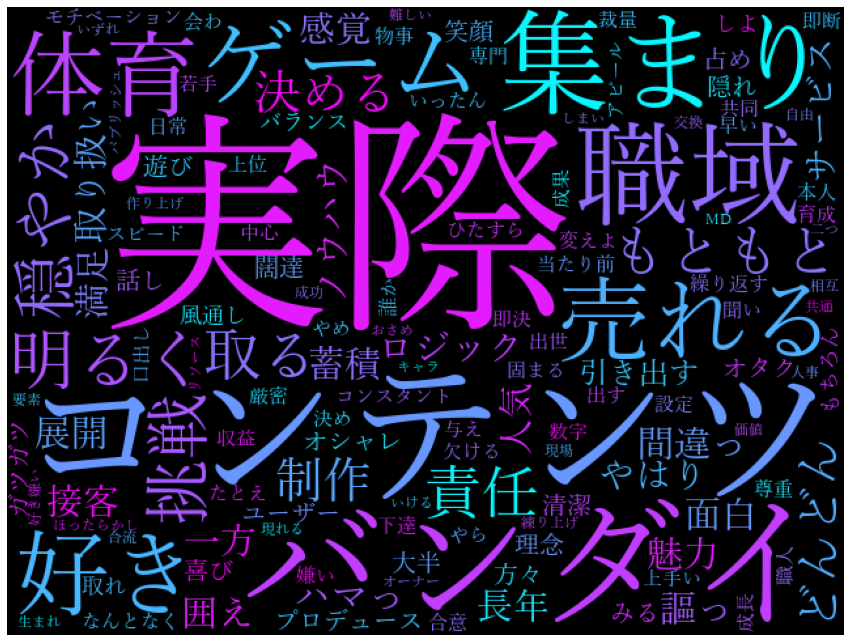

In [39]:
#指定した企業IDの企業コメントを可視化し、要約する関数

#企業ID指定
company_name = '株式会社バンダイナムコエンターテインメント'

#algos

algorithm_dic = {"lex": LexRankSummarizer(), "tex": TextRankSummarizer(), "lsa": LsaSummarizer(),\
                 "kl": KLSummarizer(), "luhn": LuhnSummarizer(), "redu": ReductionSummarizer(),\
                 "sum": SumBasicSummarizer()}

#日本語処理用のクラス
class JapaneseCorpus:
    # ①
    def __init__(self):
        self.nlp = spacy.load('ja_ginza')
        self.analyzer = Analyzer(
            char_filters=[UnicodeNormalizeCharFilter(), RegexReplaceCharFilter(r'[(\)「」、。]', ' ')],  # ()「」、。は全てスペースに置き換える
            tokenizer=JanomeTokenizer(),
            token_filters=[POSKeepFilter(['名詞', '形容詞', '副詞', '動詞']), ExtractAttributeFilter('base_form')]  # 名詞・形容詞・副詞・動詞の原型のみ
        )

    # ②
    def preprocessing(self, text):
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\r', '', text)
        #text = re.sub(r'\d', '', text)
        text = re.sub(r'\s', '', text)
        text.replace('\u3000', '')
        text = text.lower()
        text = mojimoji.zen_to_han(text, kana=True)
        text = mojimoji.han_to_zen(text, digit=False, ascii=False)
        text = ''.join(c for c in text if c not in emoji.UNICODE_EMOJI)
        text = neologdn.normalize(text)

        return text

    # ③
    def make_sentence_list(self, sentences):
        doc = self.nlp(sentences)
        self.ginza_sents_object = doc.sents
        sentence_list = [s for s in doc.sents]

        return sentence_list

    # ④
    def make_corpus(self):
        corpus = [' '.join(self.analyzer.analyze(str(s))) + '。' for s in self.ginza_sents_object]

        return corpus


#WordCloudで可視化と、レビューの要約双方を行うクラス
class company_summarize:
    def __init__(self,company_name):
        self.company_name = company_name
        self.company_id = company_df[company_df.企業名 == company_name].企業ID.unique()[0]#compane_nameをIDに変換
        self.nlp = spacy.load('ja_ginza')
        self.analyzer = Analyzer(
            char_filters=[UnicodeNormalizeCharFilter(), RegexReplaceCharFilter(r'[(\)「」、。]', ' ')],  # ()「」、。は全てスペースに置き換える
            tokenizer=JanomeTokenizer(),
            token_filters=[POSKeepFilter(['名詞', '形容詞', '副詞', '動詞']), ExtractAttributeFilter('base_form')]  # 名詞・形容詞・副詞・動詞の原型のみ
        )

    
    #Wordcloudでの可視化
    def visualize(self):
        CHASEN_ARGS = r' -F "%m\t%f[7]\t%f[6]\t%F-[0,1,2,3]\t%f[4]\t%f[5]\n"'
        CHASEN_ARGS += r' -U "%m\t%m\t%m\t%F-[0,1,2,3]\t\t\n"'
        tagger = MeCab.Tagger(ipadic.MECAB_ARGS + CHASEN_ARGS)
        #null parse
        tagger.parse('')
    
        #指定した企業IDのみに絞る
        company_text = pd.DataFrame(company_df[company_df.企業名 == self.company_name])

        #dfの本文から口コミデータを抽出し、strで連結しテキストデータへ
        all_text = company_text.本文.str.cat()
    
        #正規化
        all_text_norm = unicodedata.normalize("NFKC", all_text)
    
        #parse
        node = tagger.parseToNode(all_text_norm)

        # 指定した品詞を抽出しリストに
        word_list = []
    
        while node:
            word_type = node.feature.split(',')[0]
            if word_type in ["名詞", "動詞", "形容詞",'副詞']:
                word_list.append(node.surface)
            #ここのインデントミスると無限ループ
            node = node.next

        # リストを文字列に変換
        word_chain = ' '.join(word_list)
    
        #ストップワードリストをコピー
        stopword_list_indef = stopword_list
        
        #word_listの要素数の10%は、最も登場頻度が高いワードなのでストップリストに追加する
        fdist = Counter(word_list)
        Common_Words = fdist.most_common(n=int(len(fdist)*0.10))
        
        for common_word in Common_Words:
            stopword_list_indef.append(common_word[0])

        #社名が入らないように、stopwordlistに追加
        stopword_list_indef.append(company_text.企業名.drop_duplicates().str.cat().replace('株式会社',''))

        # ワードクラウド作成
        W = WordCloud(width=640, height=480, background_color='black', colormap='cool_r',
                      font_path='C:\Windows\Fonts\yumin.ttf', stopwords = set(stopword_list_indef)).generate(word_chain)
        # 表示設定
        plt.figure(figsize = (15, 12))
        plt.axis('off')

        plt.imshow(W)
        
    #前処理、コーパスリスト作成など
    def preprocessing(self, text):
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\r', '', text)
        #text = re.sub(r'\d', '', text)
        text = re.sub(r'\s', '', text)
        text.replace('\u3000', '')
        text = text.lower()
        text = mojimoji.zen_to_han(text, kana=True)
        text = mojimoji.han_to_zen(text, digit=False, ascii=False)
        text = ''.join(c for c in text if c not in emoji.UNICODE_EMOJI)
        text = neologdn.normalize(text)

        return text

    def make_sentence_list(self, sentences):
        doc = self.nlp(sentences)
        self.ginza_sents_object = doc.sents
        sentence_list = [s for s in doc.sents]

        return sentence_list

    def make_corpus(self):
        corpus = [' '.join(self.analyzer.analyze(str(s))) + '。' for s in self.ginza_sents_object]

        return corpus
    
    #文章内容要約
    def summarize_sentences(self,sentences_count=10, algorithm="lex", language="japanese"):
        
        
        company_split_df = pd.DataFrame(company_df[company_df.企業名 == self.company_name])
        if company_split_df.shape[0] >= 55:
            company_split_df = company_split_df.sample(n=55)
        #任意の企業名のレビューstrを取り出す
        all_text = company_split_df.本文.str.cat()
        all_text_norm = unicodedata.normalize("NFKC", all_text)
        sentences=''.join(all_text_norm)
        
        #JPコーパスクラス継承
        corpus_maker = JapaneseCorpus()
        preprocessed_sentences = corpus_maker.preprocessing(sentences)
        preprocessed_sentence_list = corpus_maker.make_sentence_list(preprocessed_sentences)
        corpus = corpus_maker.make_corpus()
        parser = PlaintextParser.from_string(" ".join(corpus), Tokenizer(language))

        try:
            summarizer = algorithm_dic[algorithm]
        except KeyError:
            print("algorithm name:'{}'is not found.".format(algorithm))

        summarizer.stop_words = get_stop_words(language)
        #sentences_countは文書に一定の割合をかけた値でもよいが、読みやすさ重視で10センテンス固定長とする
        #int(len(corpus)*0.1)
        summary = summarizer(document=parser.document, sentences_count=10)
        
        
        if language == "japanese":
            return str("".join([str(preprocessed_sentence_list[corpus.index(sentence.__str__())]) for sentence in summary]))
        else:
            return str("".join([sentence.__str__() for sentence in summary]))

#run
if __name__ == '__main__':
    C = company_summarize(company_name)
    
    #結果の表示
    print('\033[1m' + C.company_name + '\033[0m'+ '\n')
    #company_info_dfから該当企業のスコアを表示
    print('\033[1m' + '該当企業の分野別評価' + '\033[0m'+ '\n')
    display(company_info_df_processed[company_info_df_processed.企業名 == company_name].drop('業種',axis=1))
    #該当企業の業種の平均スコアを表示
    print('\033[1m' + '該当企業の業種平均評価' + '\033[0m' + '\n')
    
    #業種平均を表示
    company_info_mean = company_info_df_processed.groupby('業種').agg(np.mean).round(2)
    display(company_info_mean[company_info_mean.index == company_info_df[company_info_df.企業名 == company_name].業種.str.cat()])

    print('------------------------')
    #WordCloudを表示する
    C.visualize()

    #文書要約を表示 読みやすさ重視で10センテンス固定長とする
    print(C.summarize_sentences(sentences_count=10, algorithm="lex", language="japanese"))

In [42]:
(company_info_mean[company_info_mean.index == company_info_df[company_info_df.企業名 == company_name].業種.str.cat()])

,月残業時間,有給消化率,平均年収,総合スコア,社員の士気,風通し,社員相互尊重,20代成長性,長期育成,コンプラ,評価納得感,待遇満足度,会社年齢
業種,,,,,,,,,,,,,
ゲーム関連、玩具,27.36,61.68,551.24,3.04,2.88,3.08,3.12,2.82,2.32,4.02,4.02,2.93,41.47


In [45]:
#全投稿のコサイン類似度を判定したい
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Mecabアナライザ
def mecab_analyzer(text):
    #正規化
    text = unicodedata.normalize("NFKC", text)
    #text = re.sub(r'\u3000','',text)
    text.replace('\u3000', '')
    tagger = MeCab.Tagger("-Owakati")
    node = tagger.parseToNode(text)

    # 指定した品詞を抽出しリストに
    word_list = []
    
    while node:
        word_type = node.feature.split(',')[0]
        if word_type in ['名詞', '形容詞', '副詞', '動詞','接尾辞']:
            word_list.append(node.surface)
        #ここのインデントミスると無限ループ
        node = node.next
    # リストを文字列に変換
    word_chain = ' '.join(word_list)
    return word_list

#token格納用リスト
token_list = []

for review in company_df.本文:
    review_token = mecab_analyzer(review)
    token_list.append(' '.join(review_token))

In [53]:
#TfIdfインスタンス作成
vec = TfidfVectorizer(analyzer=mecab_analyzer,
                      stop_words=stopword_list,
                      min_df=10,#あまりにも出てこないワードは対象外
                      ngram_range=(1,2))#bigram/unigram/を考慮する
                      
                      
                    
#tfidf行列を作成
tfidf_matrix = vec.fit_transform(token_list)

In [54]:
tfidf_matrix

<39285x7446 sparse matrix of type '<class 'numpy.float64'>'
	with 1443337 stored elements in Compressed Sparse Row format>

In [7]:
import pickle

tfidf_matrix = pickle.load(open("tfidf_matrix.pkl", "rb"))

vec = pickle.load(open("tfidf_vec.pkl", "rb"))
vec.set_params(analyzer=mecab_analyzer)

TfidfVectorizer(analyzer=<function mecab_analyzer at 0x0000013BAF812F78>,
                max_df=0.05, min_df=10, ngram_range=(1, 3),
                stop_words=['会社', 'いい', '経緯', '主義', '行う', '理解', '受け', 'しまっ',
                            '提供', '活動', '拡大', '変更', '不足', '従業', 'すぎ', 'とっ',
                            'おら', '具体', '内容', '正しい', '通り', '可能', '生活', '異なり',
                            '規模', '職員', '風土', 'リーダー', '変われ', '形成', ...])

In [58]:
import pickle
vec.set_params(analyzer='word')
# 保存 
pickle.dump(vec, open("tfidf_vec.pkl", "wb"))
pickle.dump(tfidf_matrix,open('tfidf_matrix.pkl',"wb"))

In [8]:
jobtype_dict = {}
with open('./jobtype.csv','r',encoding='cp932') as f:
    for k in f:
        ab = k.strip().split(',')
        if ab[0] not in jobtype_dict:
            jobtype_dict[ab[0]] = ab[1]

            

#職種の分類は以下の通り        
"""
その他
コーポレート・管理・総務
営業職
事務
マーケティング職
製造
研究開発
人事
開発・設計
企画系
経理財務
SE/PM系
マネジメント
エンジニア系
デザイナー
法務

"""
#以下にjobtypeの辞書を用意した
jobtype_list_dict = {0:'その他',1:"コーポレート・管理・総務",2:'営業職・販売',3:'事務',4:'マーケティング職',
                5:'製造',6:'研究開発',7:'人事',8:'開発・設計・技術',9:'生産管理・調達・物流',10:'マネジメント',11:'企画系',
                12:'現業',13:'経理財務',14:'SE/PM系',15:'エンジニア系',16:'専門職',17:'コンサルタント',18:'デザイナー',19:'法務'}


In [57]:
#任意の文字列の入力と、職種IDをうけとり、指定した職種IDにマッチし、入力と類似したレビューを持つ企業名とレビューを返す関数
def similar_company(input_text,jobtype=None):
    '''
    見たいレビューの職種を限定したい場合は
    以下のjobtype_listのindex番号を引数で渡し、指定すること(指定しなくてもOK)
    (基本的には「その他」は分類不能なもの(「総合職」、「本社」、「～～会社xx事業部」)が多いです)
    
jobtype_list_dict = {0:'その他',1:"コーポレート・管理・総務",2:'営業職・販売',3:'事務',4:'マーケティング職',
                5:'製造',6:'研究開発',7:'人事',8:'開発・設計・技術',9:'生産管理・調達・物流',10:'マネジメント',11:'企画系',
                12:'現業',13:'経理財務',14:'SE/PM系',15:'エンジニア系',16:'専門職',17:'コンサルタント',18:'デザイナー',19:'法務'}
    
    '''
    #tokenization
    tokens = mecab_analyzer(input_text)
    #トークンを格納したリストを作成
    token_list = []
    token_list.append(' '.join(tokens))
    sample_vector = vec.transform(token_list)

    # 計算した文書のtfidf_matrixと指定した文字列のベクトルのコサイン類似度を計算
    text_similarity = cosine_similarity(sample_vector, tfidf_matrix)
    
    # 類似度が0.4以上の要素の数を取り出す
    num_of_similarities = (np.sum([x > 0.3 for x in text_similarity]))

    #類似度でsortとargsortして、類似度とインデックス双方を取り出す
    top_indices = np.argsort(-text_similarity)[0][:num_of_similarities].tolist()
    top_similarity = np.sort(text_similarity.ravel())[::-1][:num_of_similarities].tolist()
    
    #dfのハコを作り
    answer_df = pd.DataFrame(columns=['類似度','企業名', '評価', '本文', '職種', '経験年数','現職/退職','新卒/中途','性別'])
    
    #カラム内の文字数。デフォルトは50なので変更
    pd.set_option("display.max_colwidth", 1500)
    
    #行数上限も変更し
    pd.set_option("display.max_rows", 101)

    #forループで連結する
    for a,b in zip(top_indices,top_similarity):
        index_data = company_df.iloc[a]
        answer_df =answer_df.append({'類似度': b,'企業名': index_data[0], 
                                     '評価': index_data[4],'本文':index_data[5],
                                     '職種':index_data[8],'経験年数':index_data[9],
                                     '現職/退職':index_data[10],'新卒/中途':index_data[11],
                                     '性別':index_data[12]},ignore_index=True)
        
    #出来上がったdfを、company_info_dfとマージ
    answer_df_marged = pd.merge(answer_df,pd.DataFrame(company_info_df[['企業名','総合スコア']]),on='企業名',how='inner')
    
    #企業風土の評価スコアはdrop
    #answer_df_marged = answer_df_marged.drop('評価',axis=1)
    #出来上がったdfを、類以度でsort　topは表示件数
    top = 30
    answer_df_marged_g = answer_df_marged.set_index(['総合スコア','企業名'])
    
    #jobtypeの入力に応じて出力を変える
    #会社の総合スコア順に表示
    
    if jobtype is None:
        return answer_df_marged_g.sort_index(ascending=False)[:top]
    
    else:
        answer_df_marged_g['職種'] =  answer_df_marged_g['職種'].map(jobtype_dict)
        job_adm = answer_df_marged_g[answer_df_marged_g['職種'] == jobtype_list_dict[jobtype]].reset_index()
        job_adm_s = job_adm.set_index(['総合スコア','企業名'])
        return job_adm_s.sort_index(ascending=False)[:top]
        
        
        
    #return answer_df_marged_g[:top].sort_values('総合スコア',ascending=False)

    #return answer_df_marged.sort_values(['総合スコア'],ascending=False).reset_index().drop('index',axis=1)[:top]


#ここに検索したい企業文化をフリーワードで入力する
input_text = '優秀な人が多い'
similar_company(input_text)

類似度   評価  \
総合スコア 企業名                                                               
4.54  ボストン・コンサルティング・グループ合同会社（旧：株式会社ボストン・コンサルティング・グループ）  0.317491  4.1   
4.48  株式会社リンクアンドモチベーション                                 0.388966  4.4   
4.45  中外製薬株式会社                                          0.448303  3.5   
4.30  株式会社電通国際情報サービス                                    0.302870  3.1   
      アビームコンサルティング株式会社                                  0.322599  4.4   
4.29  株式会社野村総合研究所                                       0.335757  3.9   
4.22  日本マイクロソフト株式会社                                     0.480576  3.5   
4.18  野村不動産株式会社                                         0.736301  4.1   
4.07  都築電気株式会社                                          0.311106  2.5   
4.06  株式会社ディー・エヌ・エー(DeNA)                               0.456371  3.5   
      株式会社ディー・エヌ・エー(DeNA)                               0.301378  3.9   
3.99  株式会社丹青社                                           0.391489  3.4   
      日鉄ソリューションズ株式会社                                    0.513222  3.5   
      日鉄ソリューションズ株式会社                                    0.400135  4.0   
3.92  パーソルキャリア株式会社                                      0.355063  3.8   
      パーソルキャリア株式会社                                      0.339490  3.9   
3.86  株式会社キャリアデザインセンター                                  0.357830  3.6   
      東京エレクトロン株式会社                                      0.616584  3.8   
3.81  株式会社リブセンス                                         0.330279  3.4   
3.80  楽天グループ株式会社（旧：楽天株式会社）                              0.407686  3.8   
      五洋建設株式会社                                          0.426165  3.1   
3.79  アステラス製薬株式会社                                       0.305197  3.5   
      アサヒビール株式会社                                        0.353157  3.8   
3.77  ライオン株式会社                                          0.366623  3.6   
3.76  株式会社三井住友銀行                                        0.353428  4.3   
3.74  株式会社ベネッセコーポレーション                                  0.363754  3.0   
      帝人株式会社                                            0.394830  3.1   
3.73  株式会社じげん                                           0.323327  3.3   
      AGC株式会社                                           0.340356  3.0   
3.71  株式会社物語コーポレーション                                    0.375184  3.1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          本文  \
総合スコア 企業名                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
4.54  ボストン・コンサルティング・グループ合同会社（旧：株式会社ボストン・コンサルティング・グループ）  スピード感と正確性を重視しています。みんなが仕事に対して、そしてこの会社で働いていることに対してプライドを持っています。それは良くも悪くもだと思いますが。ちょっと変わっているが、能力の高い人が多いと思います。学歴が高い人ばかりなので、話は面白いですね。オフィスがきれいで働きやすい雰囲気があります。長期的なキャリアを積もうとおもっいる人には仕事のタフさを乗り越えられればいい会社だし、短期的に成長したいと思って入る人でも成長の場としてはよいでしょう。自分のネットワークを広げるうえでもうってつけなのではないかと思います。ここで働いていた、というのは経歴書にもよく見えることが多いというのが印象です。能力がたかく、かわった面白い人もたくさんいるが、ときには嫌な人もいます。それはどこの会社でも同じなのだとは思いますが・・・・・・。また、サポートスタッフの質の高さはすごいとおもいます。コンサルの人たちも能力が高いですが、それを会社全体で支えようとする気持ちがあるし、やはり仕事にプライドを持つというのは、仕事に真剣に取り組んでいる証拠。自分のパフォーマンスを上げようとしている人が多い。もともと能力が高い人が多いというのもありますが。

In [29]:
tokens = mecab_analyzer('年功序列')
tokens
gh=[]
gh.append(' '.join(tokens))
sample_vector = vec.transform(gh)

sample_vector

<1x3844 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [24]:
import MeCab
from gensim.models import KeyedVectors
import numpy as np
from gensim.models import word2vec
import logging
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument


In [ ]:
# モデルのロード(モデルが用意してあれば、ここからで良い)
m = Doc2Vec.load('./model/openwork.model')

In [22]:
#企業ごとコメント全部をベクトル化
#まず企業毎のレビューを全部くっつけて、1企業全レビューのdfにする
all_docs = pd.DataFrame(company_df.groupby('企業名').本文.apply(list).apply(' '.join))


In [ ]:
#token格納用リスト
token_list = []
    
for review in all_docs.本文:
    review_token = mecab_analyzer(review)
    token_list.append(' '.join(review_token))
    
trainings = [TaggedDocument(words = data.split(' '),tags = [i]) for i,data in enumerate(token_list)]


#parameter: https://github.com/jkatsuta/18_4q_doc2vec/blob/master/experiments/exp_params_setup1.ipynb
model = Doc2Vec(documents=trainings, dm=1,
                min_alpha=.1e-4, size=200,
                window=10, min_count=5,
                worker=-1,epochs=50
                )


print('\n訓練開始')
for epoch in range(50):
    print('Epoch: {}'.format(epoch + 1))
    model.train(trainings,total_examples=model.corpus_count, epochs=model.epochs)


# モデルのセーブ
model.save("./model/openwork_uniquecompany.model")


In [25]:
# モデルのロード(モデルが用意してあれば、ここからで良い)
m = Doc2Vec.load("./model/openwork_uniquecompany.model")

#企業名を引数にとり、その企業のコメントベクトルに類似したベクトルを持つ企業名と類似度を表示する関数
def company_comparison(company_name):
    identified_company_docs = all_docs[all_docs.index == company_name]
    input_text = identified_company_docs.本文.str.cat()
    #Mecabによって形態素解析
    mecab_input = mecab_analyzer(input_text)
    
    #docvecsによる類似性判定結果
    #類似度TOP10の企業を表示
    similarity = (m.docvecs.most_similar(positive=[m.infer_vector(mecab_input)],topn=10))
    
    #格納用空リスト
    return_list=[]
    for num,similarity in similarity:
        return_list.append([all_docs.index[num],similarity])
    #df化
    output_df = pd.DataFrame(return_list,columns=['企業名','類似度']).sort_values('類似度',ascending=False)
    return output_df[1:] #自社が最も類似しているので、1行目は除いて、2行目から表示
    
    
company_comparison('ヤフー株式会社')

,企業名,類似度
1,株式会社エムティーアイ,0.529294
2,株式会社ディー・エヌ・エー(DeNA),0.493590
3,株式会社アイスタイル（インターネット）,0.492756
4,トランス・コスモス株式会社,0.482927
5,株式会社じげん,0.479647
6,クックパッド株式会社,0.476943
7,株式会社CARTA HOLDINGS,0.475818
8,ソフトバンク株式会社,0.473055
9,株式会社ニコン,0.472817


In [58]:
all_docs[all_docs.index == "グーグル合同会社"]

,本文
企業名,
グーグル合同会社,昇給のチャンスは２回あります。ただ、会社の期待値がとても高いため、昇給の基準を満たすことは難しいと思います。360度評価が行われます。昔よりは改善されましたが、やはり同僚からの評価は参考程度な気がします。福利厚生は、一般的な日系企業とは異なります。ギフトはたくさんもらえますが、住宅補助はありません。オフィス環境は良いです。飲み物も飲み放題です。コロナ禍は在宅勤務です。イベントごとに会社オリジナルグッズが配れれます。それよりも住宅手当てなどで応えて欲しいですが、現状そのような漢字です。車内パーティーなども盛んで、繰りますになると全社員参加のクリスマスパーティーなどがあります。楽しいです。休日休暇 商品の性質上、勤務時間は関係ないとも言えます。どんな日、どんな時間でも連絡がきます。事務職など、ワークライフブランスがとりやすい職種はおっきく性質が異なると思います。多様な働き方支援 副業は可能です。企業カルチャー・社風 上昇志向がある方向けです。ただ唱えるだけだはなく、かなり社風を重んじる傾向があります。組織体制・コミュニケーション 語学力は必要です。語学力がない場合、入社は厳しい、もしくは入社後厳しいと思います。 大企業になるに連れ堅苦しいプロセスや根回しの必要性等は増えたが、それでも全体的にオープンで、誰の意見にも耳を傾け尊重するような社内文化を保つ事に、経営層レベルで努力をし続けている。自己促進、行動力が前提の環境。英語でも自分の意見を理論立てて言える事、データをもった判断・主張が出来る事、等が求められる。また、例えば本業務以外の事にも積極的に関わってプロジェクトチームを作り、促進していく事で自分のインパクト、社内での露出度を上げる事が重要（これらの活動も昇進の際の評価基準となる）。 アメリカの会社だけあって、とにかくフェアであろうとする文化がある。以下は、私が前職で日系メーカーに勤めていた際、決して見ることがなかったことである。・どんな下っ端でも誰かが昇進した場合、事業部全体にアナウンスされ、なぜそうなったのかの理由を事業部トップ発信のメールで短くても必ず言及される。・外資系レジュメなので、年齢（生年月日）を書く必要がなく、年齢がわからない状態で採用される・家族を何より重視する文化があり、６時を過ぎるとオフィスから人がいなくなり、７時を過ぎるともはや誰もいなくなる書くとキリがないのですが、いわゆるアメリカ文化の会社だと思う。 一般的なGoogleのイメージは裁量の多く自由な組織というものだと思う。クラウドも基本的にはその方向性は踏襲しようとしているが、広告やYouTubeといった非クラウド部門とは雰囲気が少々異なる。まず、TKがCEOへ就任後は特にUSのディレクター以上はかなり入れ替えられダイアンの頃よりトップダウンの風潮が強くなった。また、新卒も含めた若い女性も多い広告等の組織とは異なりSIer上がりの男性社員が多いためそれに応じた雰囲気があり、オフィスが渋谷・六本木と別れた後は特に顕著に現れている。 独自の価値観、信念を徹底して浸透させており、１つの国のような印象をうける。採用基準を厳しくし、入社した社員を信じ性善説で物事を進める会社。その為マイクロマネジメントを嫌い、現場のコーチングをマネジャー陣には徹底させるなどの取り組みが進んでいる。一方、会社のプログラムを設計している側は、特に広告ビジネスのロングテール側のはビジネスなどに関しては、ある程度のレベルの人間であれば回るような仕組み設計が徹底されている。 ▷良い点Google日本支...


In [59]:
all_docs[all_docs.index == "日本マイクロソフト株式会社"]

,本文
企業名,
日本マイクロソフト株式会社,米国本社で制作したオンラインでの必須のトレーニングが数か月ごとに受講しなくてはならず、CEO のメッセージや、ドラマ仕立てになったコンプライアンス研修、製品トレーニングなど、視聴が必要です。そこで新入社員のみならず既存の社員に対して、コンプライアンス準拠の意識や、ビジネス方向性、プライオリティーなどのメッセージがトップダウンで全世界に浸透されます。直属の上司や日本の社長からのトップダウンのメッセージは非常に少ないです。社員は自ら考えて動くことが要求され、与えられている仕事だけをやっている人は評価が低く、評価は部門内での相対評価で、ボトム1割など、評価低い状態が続くと、転職をお勧めされます。いったん低い評価が付くと、社内異動も、移動先の上司が評価を見れるので、現実的にはできなくなります。自分自身での成績だけでなく、他者への貢献が求められます。部門内(数十から100人～)で、誰もが知っているような働きぶりができると、昇給も早くなります。数年前の情報ですが、定年退職まで勤め上げた人は1桁しかいませんでした。定年退職を望む人、競争を望まない人には、つらい職場になります。相対評価の中で、勝ち続ける自身のある人にはお勧めできます。最低でも、少なくとも評価でボトムに入らないように能動的に仕事ができる人で、マイクロソフトを足掛けにして、その次のキャリアを探している人には選択肢として検討してよいと思います。 みんなが非常にきょうりょくてきであり、非常にコラボレーションが高い組織であるとは思っております。一人一人が生産性高く仕事をしようとしており、何かお願い事をするときも嫌な顔する人は私がいたときは非常に少なかったと思っております。ただ、いまは人も増えていたり社長が変わっており、どのようになっているかは定かではありませんが、知り合いに聞く限りはグローバルとしてもそのような社風を目指しており、あまり変わっていないことは想像できます。 テクノロジーを用いて地球上の全ての組織と個人をエンパワーする、という壮大なミッションのもと、言わずと知れたグローバルな組織である。掲げているミッションを心から達成しようと思って新卒社員は入社しますが、配属される部署や現場によってはなかなかそういったミッションを日々の仕事で感じられることは少ない。特に営業所である日本にとっては数字が全てであり、営業部門ではとにかく数字を求められる。数字が達成しているときの組織はとても居心地が良いが、数字が達成していないと理不尽なオーダーが山のように降ってくる。上層部からのそういったオーダーを食い止めてくれるマネージャーであれば働きやすいが、それを全て現場に丸流しするマネージャーに当たると、一気に働きづらくなる。結局は日本、アジア、HQへと続く長いレポートラインの中で、それぞれが中間管理職として自分が良い評価を得て、悪い評価を得ないようにする社内政治に巻き込まれることが多く、本質的な仕事以外の負担に辟易する。 いくつかのコアバリューがあり、それらをもとにアクションプランを組み立てる。コアバリューには共感できるが、必ずしもそのバリューに沿ったアクションプランを立てられる状況とは限らない。そういった際にも、要領よくアクションできる人材が求められる。相互を尊重する文化があり、マネージャー層から末端まで浸透している。リモートワークも当たり前のように行なっており、やることをやっていれば働き方はとて自由。一方で、個人プレーで仕事の多くが完結するため、能動的に周りとコミュニケーションを取ることができなければ、仕事が...


In [60]:
#検索したいワード
input_text = '残業が少なく働きやすい'

#Mecabによって形態素解析
mecab_input = mecab_analyzer(input_text)

#docvecsプロパティのmost_similarメソッドを使用すると、
#ラベル付した記事からコサイン類似度を計算して類似した記事を取得することができる
#類似文書のindexを取得
#positive:類似 negative:類似していない
print(m.docvecs.most_similar(positive=[m.infer_vector(mecab_input)],topn=5))

[(157, 0.5178278684616089), (503, 0.5095049142837524), (1305, 0.4998290538787842), (89, 0.4921707808971405), (523, 0.49093544483184814)]


In [69]:
trainings[157]

TaggedDocument(words=['組織', '体制', '古い', '昔', 'ながら', '仕事', 'やり', '方', '行っ', 'おり', '時代', '変化', '取り残さ', '若手', 'とっ', '足り', '思い', '企業', '文化', '法令', '強く', '意識', 'し', 'おり', '仕事', '多い', '製品', '出す', '前', '仕事', '時間', 'とら', '他社', '先', '越さ', 'こと', '多く', 'あり', '一般', '職', '特許', '書く', 'ノルマ', 'あり', '特許', 'アイデア', '無く', 'ノルマ', 'ある', '毎年', '苦労', 'し', '組織', '風土', '配属', 'さ', '部門', 'よっ', '風土', '大きく', '異なり', 'あまり', '事前', 'ヒヤリング', '参考', 'なら', '思い', '法令', '遵守', '徹底', 'さ', 'おり', '全般', '的', 'ホワイト', '企業', 'ある', '思う', '法令', '遵守', '徹底', 'する', 'あまり', '業務', '監査', '過剰', '監査', '対応', 'する', 'ため', '無駄', '業務', '発生', 'する', 'こと', '日常', '茶飯', '事', 'ある', '理由', '社内', '手続き', '時間', 'かかる', 'こと', '多く', 'スピード', '感', '欠ける', '部門', 'よる', '思う', '基本', '的', '社内', '風通し', '良い', '社内', '役職', '呼ぶ', 'こと', 'ほとんど', 'なく', 'さん', '呼ぶ', 'こと', '一般', '的', '若手', 'あっ', '自', '部門', '本部', '長', 'クラス', 'コミュニケーション', 'する', '機会', 'あり', '意見', '言う', 'こと', 'できる', 'ビジネス', 'ユニット', 'ごと', '組織', '分かれ', 'おり', '組織', '間', '壁', '高い', '思う', '横', '連携', 'もう', '少し', '上手く', 'できる

In [130]:
#企業毎にコメント数がバラバラな問題があるので、抽出件数を揃えたい
#企業ごとコメントを8件RANDOMに抽出し、ベクトル化したらどうなるか
AK = pd.DataFrame(company_df.groupby('企業名').本文.apply(lambda x:x.sample(n=5,random_state=0,replace=True)))
#df.sampleにかんして参照 https://analytics-note.xyz/programming/dataframe-sample-doc/

all_docs_5sentences = pd.DataFrame(AK.groupby('企業名').本文.apply(list).apply(''.join))

#token格納用リスト
token_list = []
    
for review in all_docs_5sentences.本文:
    review_token = mecab_analyzer(review)
    token_list.append(' '.join(review_token))
    
trainings = [TaggedDocument(words = data.split(' '),tags = [i]) for i,data in enumerate(token_list)]

#parameter: https://github.com/jkatsuta/18_4q_doc2vec/blob/master/experiments/exp_params_setup1.ipynb
model = Doc2Vec(documents=trainings, dm=1,
                min_alpha=.1e-4, size=200,
                window=10, min_count=5,
                worker=-1,epochs=50
                )


print('\n訓練開始')
for epoch in range(50):
    print('Epoch: {}'.format(epoch + 1))
    model.train(trainings,total_examples=model.corpus_count, epochs=model.epochs)


# モデルのセーブ
model.save("./model/openwork_uniquecompany_8sentences.model")


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")



訓練開始
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50


In [ ]:
# モデルのロード(モデルが用意してあれば、ここからで良い)
m = Doc2Vec.load("./model/openwork_uniquecompany_8sentences.model")

#企業名を引数にとり、その企業のコメントベクトルに類似したベクトルを持つ企業名と類似度を表示する関数
def company_comparison(company_name):
    identified_company_docs = all_docs[all_docs.index == company_name]
    input_text = identified_company_docs.本文.str.cat()
    #Mecabによって形態素解析
    mecab_input = mecab_analyzer(input_text)
    
    #docvecsによる類似性判定結果
    #類似度TOP10の企業を表示
    similarity = (m.docvecs.most_similar(positive=[m.infer_vector(mecab_input)],topn=10))
    
    #格納用空リスト
    return_list=[]
    for num,similarity in similarity:
        return_list.append([all_docs.index[num],similarity])
    #df化
    output_df = pd.DataFrame(return_list,columns=['企業名','類似度']).sort_values('類似度',ascending=False)
    return output_df[1:] #自社が最も類似しているので、1行目は除いて、2行目から表示
    
company_comparison('ヤフー株式会社')

In [16]:
'./static/cloud_pic' + str(0) + '.jpg'

'./static/cloud_pic0.jpg'